In [1]:
import glob
import pandas as pd
import numpy as np

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv1D, MaxPooling1D
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold
from keras.layers import LSTM, Dense, Conv1D, TimeDistributed, Flatten, Activation, Dropout, Bidirectional
from keras.callbacks import History, TensorBoard, Callback
import keras.initializers as KI
from keras.layers import BatchNormalization
from sklearn.metrics import f1_score, precision_score, recall_score

from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

2023-07-10 18:51:58.229705: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

#merge the gaze labelled data for each participant and document
gaze_path = "../../data/working/gaze_labelled/"

gaze_list = [pd.read_csv(data, index_col=0) for data in sorted(glob.glob(gaze_path + "/*/*"))]
gaze_data = pd.concat(gaze_list, ignore_index=True, sort=False)

In [3]:

# features = ['left_gaze_x', 'left_gaze_y', 'left_pupil',
#        'right_gaze_x', 'right_gaze_y', 'right_pupil','understand','interest']

gaze_data = gaze_data[(gaze_data['document'] != 'd20') & (gaze_data['document'] != 'd06')]
#gaze_data = gaze_data[(gaze_data['participant'] != 'p01') & (gaze_data['document'] != 'd16') ]
participants = gaze_data.participant.unique()
documents = gaze_data.document.unique()

<Axes: xlabel='interest'>

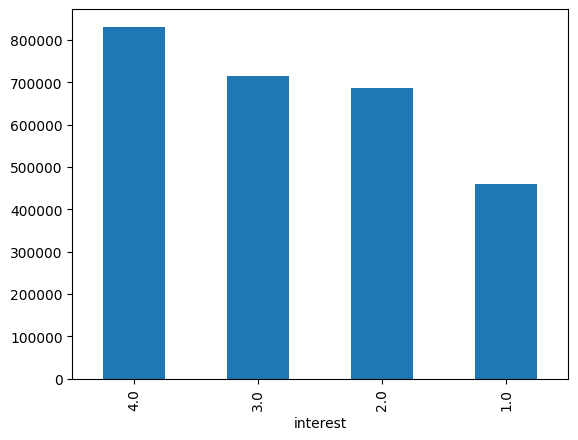

In [4]:
# gaze_data['interest'] = gaze_data['interest'].replace([1,2,3,4], [0,1,2,3])
# gaze_data['understand'] = gaze_data['understand'].replace([1,2,3,4], [0,1,2,3])
gaze_data.interest.unique()
gaze_data['interest'].value_counts().plot(kind='bar')


In [5]:
conditions = [(gaze_data['interest'] <=2 ),(gaze_data['interest'] > 2)]

class_values = [0,1]
gaze_data['interest_bin'] = np.select(conditions, class_values)

In [6]:
gaze_data['interest_bin'].value_counts()


interest_bin
1    1545207
0    1145751
Name: count, dtype: int64

In [7]:
features = ['left_gaze_x', 'left_gaze_y',
       'left_position_x', 'left_position_y', 'left_position_z', 'left_pupil',
       'right_gaze_x', 'right_gaze_y', 'right_position_x', 'right_position_y',
       'right_position_z', 'right_pupil','understand','interest_bin']

In [8]:
def normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

def get_frames(df, frame_size, step_size, label_name):

    N_FEATURES = len(features) - 1

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, step_size):
        for column in df.columns:
            if column!=label_name:
                column = df[column].values[i: i + frame_size]
                frames.append([column])
        else:
            
        # Retrieve the most often used label in this segment
            label = stats.mode(df[label_name][i: i + frame_size])[0][0]
            labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [14]:
samp_freq = 60
frame_size = samp_freq*30 
step_size = samp_freq*15 

def prepare_data(data, fold):
  
    df_val = data[data['participant'] == participants[fold]]
    df_train = data[data['participant'] != participants[fold]]

    # df_train.drop(['participant','document'], axis=1, inplace=True)
    # df_val.drop(['participant','document'], axis=1, inplace=True)

    df_train = df_train[features]
    df_val = df_val[features]
    
    for col in df_train.columns:
        
        if col != 'interest_bin':        
            df_train[col] = normalize(df_train[col])
            df_val[col] = normalize(df_val[col])

    x_train, y_train = get_frames(df_train, frame_size, step_size, 'interest_bin')
    num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
    num_classes = 1
    print (x_train.shape, y_train.shape)

    input_shape = (num_time_periods * num_sensors)
    x_train = x_train.reshape(x_train.shape[0], input_shape)

    # x_train = x_train.astype("float32")
    # y_train = y_train.astype("float32")

    #y_train = np_utils.to_categorical(y_train, num_classes)
    print(y_train.shape)

    x_val, y_val = get_frames(df_val, frame_size, step_size, 'interest_bin')

    num_time_periods1, num_sensors1 = x_val.shape[1], x_val.shape[2]

    input_shape1 = (num_time_periods1 * num_sensors1)
    x_val = x_val.reshape(x_val.shape[0], input_shape1)

    # x_val = x_val.astype("float32")
    # y_val = y_val.astype("float32")

    #y_val = np_utils.to_categorical(y_val, num_classes)

    return num_time_periods, num_sensors, x_train, x_val, y_train, y_val

In [15]:
# Hyper-parameters
BATCH_SIZE = 256
EPOCHS = 5

In [16]:
conf_matrix_list_of_arrays = []
scores = []
acc_per_fold = []
loss_per_fold = []
f1_per_fold = []
prec_per_fold = []
rec_per_fold = []

def build_model(num_time_periods, num_sensors, num_classes, input_shape):
  # 1D CNN neural network
    
    model = Sequential()
    model.add(Reshape((frame_size, num_sensors), input_shape=(input_shape,)))
    model.add(Conv1D(100, 3, activation='relu', input_shape=(frame_size, num_sensors)))
    model.add(Conv1D(100, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(50, 10, activation='relu'))
    model.add(MaxPooling1D(2))

    model.add(Conv1D(15, 2, activation='relu'))
    #model.add(MaxPooling1D(2))

    model.add(LSTM(32))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    #model.add(Dense(64, activation='relu'))

    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def evaluate(num_time_periods, num_sensors,t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE):
    
    input_shape = (num_time_periods * num_sensors)
    model = build_model(num_time_periods, num_sensors, 1, input_shape)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

    history = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es], verbose=1, validation_split=0.3)
    scores = model.evaluate(val_x, val_y)
    print(f'Score : {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])
    
    
    y_pred = np.argmax(model.predict(val_x), axis=-1)
    f1_per_fold.append(f1_score(val_y, y_pred, average='weighted'))
    prec_per_fold.append(precision_score(val_y, y_pred, average='weighted'))
    rec_per_fold.append(recall_score(val_y, y_pred, average='weighted'))
    print('F1 score : ', f1_score(val_y, y_pred, average='weighted'))


    cm = confusion_matrix(val_y, y_pred, labels=[0,1])
    print('Confusion Matrix : ')
    print(cm)
    
    #conf_matrix_list_of_arrays.append(cm)
    return history, scores, y_pred, acc_per_fold, f1_per_fold

def plot_cmx(labels, predicteds, binary=False):
    cmx = confusion_matrix(labels, predicteds)
    cmx = cmx.astype('float') / cmx.sum(axis=1)[:, np.newaxis]
    if binary:
        class_names = ['not-interested', 'interested']
    else:
        class_names = ['1','2','3','4']
    plt.figure(figsize=(8, 6))
    plt.title("mean accuracy: %.2f" % accuracy_score(labels, predicteds))
    sns.heatmap(cmx, annot=True, fmt=".0%",center=1, xticklabels=class_names, yticklabels=class_names)

    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.show()

In [18]:
model_history = [] 
cvscores = []
predicted = []
labels = []

for i in range(len(participants)):
    
    pred = []
    label = []
    print("Training with participant "+ participants[i] +" left out")
    num_time_periods, num_sensors, t_x, val_x, t_y, val_y = prepare_data(gaze_data, i)
    results, scores, preds, acc, f1 = evaluate(num_time_periods, num_sensors,t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE)
    model_history.append(results)
    cvscores.append(scores[1] * 100)
    predicted.extend(preds)
    labels.extend(val_y) 
    print("Accuracy with participant " + participants[i] + ' as test :'+str(scores[1]*100))
    print("======="*12, end="\n\n\n")

#predicted = np.argmax(predicted, axis=1)
plot_cmx(labels, predicted, binary=True)
print ('Average accuracy with all the participants')

Training with participant p01 left out
(2786, 1800, 13) (2786,)
(2786,)


2023-07-12 16:53:36.181578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:53:36.183218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:53:36.184969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-07-12 16:53:36.941339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:53:36.942948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:53:36.944350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - ETA: 0s - loss: 0.5835 - accuracy: 0.7795

2023-07-12 16:53:47.462995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:53:47.464546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:53:47.466011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 12s 734ms/step - loss: 0.5835 - accuracy: 0.7795 - val_loss: 0.4319 - val_accuracy: 0.7213
Epoch 2/5
8/8 [==============================] - 3s 434ms/step - loss: 0.4171 - accuracy: 0.8426 - val_loss: 0.3929 - val_accuracy: 0.7201
Epoch 3/5
8/8 [==============================] - 3s 434ms/step - loss: 0.3848 - accuracy: 0.8436 - val_loss: 0.3907 - val_accuracy: 0.7213
Epoch 4/5
8/8 [==============================] - 3s 406ms/step - loss: 0.3780 - accuracy: 0.8467 - val_loss: 0.3737 - val_accuracy: 0.7225
Epoch 5/5
7/7 [==============================] - 1s 104ms/step - loss: 0.4336 - accuracy: 0.5373
Score : loss of 0.43356892466545105; accuracy of 53.731346130371094%


2023-07-12 16:54:03.658579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:54:03.660086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:54:03.661266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 96ms/step
F1 score :  0.06911722379836355
Confusion Matrix : 
[[ 41   0]
 [160   0]]
Accuracy with participant p01 as test :53.731346130371094


Training with participant p02 left out
(2664, 1800, 13) (2664,)
(2664,)


2023-07-12 16:54:12.050804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:54:12.052183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:54:12.053658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-07-12 16:54:12.620325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:54:12.621968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:54:12.623604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.8015

2023-07-12 16:54:20.290500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:54:20.292974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:54:20.295163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 10s 757ms/step - loss: 0.5898 - accuracy: 0.8015 - val_loss: 0.3890 - val_accuracy: 0.7088
Epoch 2/5
8/8 [==============================] - 3s 435ms/step - loss: 0.3867 - accuracy: 0.8428 - val_loss: 0.3558 - val_accuracy: 0.7063
Epoch 3/5
8/8 [==============================] - 3s 396ms/step - loss: 0.3790 - accuracy: 0.8444 - val_loss: 0.3833 - val_accuracy: 0.7075
Epoch 4/5
8/8 [==============================] - 3s 407ms/step - loss: 0.3679 - accuracy: 0.8450 - val_loss: 0.4077 - val_accuracy: 0.7100
Epoch 5/5
11/11 [==============================] - 1s 77ms/step - loss: 0.1747 - accuracy: 0.9567
Score : loss of 0.17466308176517487; accuracy of 95.66563367843628%


2023-07-12 16:54:36.027916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:54:36.029063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:54:36.030305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 1s 66ms/step
F1 score :  0.07720243581562797
Confusion Matrix : 
[[ 70   0]
 [253   0]]
Accuracy with participant p02 as test :95.66563367843628


Training with participant p05 left out
(2825, 1800, 13) (2825,)
(2825,)


2023-07-12 16:54:39.997697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:54:39.998856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:54:40.000110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-07-12 16:54:40.568004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:54:40.570457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:54:40.572445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - ETA: 0s - loss: 0.5651 - accuracy: 0.7977

2023-07-12 16:54:48.468672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:54:48.470898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:54:48.472765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 10s 794ms/step - loss: 0.5651 - accuracy: 0.7977 - val_loss: 0.4099 - val_accuracy: 0.7241
Epoch 2/5
8/8 [==============================] - 4s 446ms/step - loss: 0.3937 - accuracy: 0.8528 - val_loss: 0.4358 - val_accuracy: 0.7182
Epoch 3/5
8/8 [==============================] - 3s 405ms/step - loss: 0.3870 - accuracy: 0.8518 - val_loss: 0.4969 - val_accuracy: 0.7193
Epoch 4/5
8/8 [==============================] - 3s 444ms/step - loss: 0.3745 - accuracy: 0.8538 - val_loss: 0.4230 - val_accuracy: 0.7205
Epoch 5/5
6/6 [==============================] - 1s 142ms/step - loss: 0.2797 - accuracy: 0.8580
Score : loss of 0.279728502035141; accuracy of 85.80247163772583%


2023-07-12 16:55:05.021397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:55:05.024972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:55:05.028473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 2s 92ms/step
F1 score :  0.2420076553992129
Confusion Matrix : 
[[67  0]
 [95  0]]
Accuracy with participant p05 as test :85.80247163772583


Training with participant p06 left out
(2804, 1800, 13) (2804,)
(2804,)


2023-07-12 16:55:08.727416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:55:08.728614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:55:08.729932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-07-12 16:55:09.271497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:55:09.273571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:55:09.275088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - ETA: 0s - loss: 0.5403 - accuracy: 0.8063

2023-07-12 16:55:16.862970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:55:16.864622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:55:16.866451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 9s 747ms/step - loss: 0.5403 - accuracy: 0.8063 - val_loss: 0.3719 - val_accuracy: 0.7197
Epoch 2/5
8/8 [==============================] - 3s 437ms/step - loss: 0.3974 - accuracy: 0.8461 - val_loss: 0.4155 - val_accuracy: 0.7209
Epoch 3/5
8/8 [==============================] - 3s 427ms/step - loss: 0.3948 - accuracy: 0.8451 - val_loss: 0.4320 - val_accuracy: 0.7209
Epoch 4/5
8/8 [==============================] - 4s 461ms/step - loss: 0.3867 - accuracy: 0.8481 - val_loss: 0.3639 - val_accuracy: 0.7209
Epoch 5/5
6/6 [==============================] - 1s 150ms/step - loss: 0.2544 - accuracy: 0.9290
Score : loss of 0.25435447692871094; accuracy of 92.89617538452148%


2023-07-12 16:55:33.811377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:55:33.813056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:55:33.814587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 1s 94ms/step
F1 score :  0.10098551554632877
Confusion Matrix : 
[[ 46   0]
 [137   0]]
Accuracy with participant p06 as test :92.89617538452148


Training with participant p07 left out
(2802, 1800, 13) (2802,)
(2802,)


2023-07-12 16:55:37.276369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:55:37.277787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:55:37.279268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2023-07-12 16:55:37.902760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:55:37.904111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:55:37.905393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - ETA: 0s - loss: 0.5951 - accuracy: 0.7002

2023-07-12 16:55:48.129745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-12 16:55:48.132189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-12 16:55:48.134077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 12s 1s/step - loss: 0.5951 - accuracy: 0.7002 - val_loss: 0.4268 - val_accuracy: 0.7146
Epoch 2/5
8/8 [==============================] - 4s 457ms/step - loss: 0.4361 - accuracy: 0.8582 - val_loss: 0.3508 - val_accuracy: 0.7206
Epoch 3/5
5/8 [=================>............] - ETA: 1s - loss: 0.3727 - accuracy: 0.8609

: 

: 

In [74]:
np.mean(f1)

0.26778037985731734